
# Entropy of Neural Network Encodings (MNIST, PyTorch)

This notebook illustrates how to view a trained neural network as an **encoder**
$X \to Z \to Y$ and how to estimate:

- the entropy of the **label distribution** $H(Y)$;
- the entropy of an **internal representation** $H(Z)$;
- the distribution of **predictive entropies** $H_{\text{pred}}(x)$ over the test set.

We use a small PyTorch classifier on MNIST and save two figures into the `fig/` folder:

- `figs/nn_entropy_hist_z.png`: histogram of the encoded representation $Z$ with its entropy;
- `figs/nn_entropy_layerwise.png`: bar plot comparing several entropy-type quantities
  (labels, inputs, latent code, and predictions).


In [1]:

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Make sure the figure directory exists
os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu



## 1. Load MNIST and Build DataLoaders

We load the MNIST dataset with standard normalization and create train/test loaders.
To keep the runtime reasonable, you may optionally subsample the training set.


In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),  # maps pixels to [0,1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Optional: subsample the training set for speed
# Comment out the next 3 lines if you want to use all 60k examples.
max_train = 20000
train_indices = list(range(min(len(train_dataset), max_train)))
train_dataset = Subset(train_dataset, train_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))


Train size: 20000
Test size : 10000



## 2. A Simple MLP with a Latent Representation

We define a small fully-connected network:

- input: 784-dimensional (flattened 28×28 image);
- hidden layer 1: 256 units with ReLU;
- hidden layer 2: 128 units with ReLU **(this is our latent code \(Z\))**;
- output layer: 10 logits for the MNIST digits.

We also expose the latent code $Z$ in a separate `forward_with_z` method.


In [3]:

class MLPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)  # latent Z
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Standard forward returning logits only.
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.fc1(x))
        z  = F.relu(self.fc2(h1))
        logits = self.fc3(z)
        return logits

    def forward_with_z(self, x):
        # Forward pass that also returns the latent code Z.
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.fc1(x))
        z  = F.relu(self.fc2(h1))
        logits = self.fc3(z)
        return logits, z

model = MLPEncoder().to(device)
print(model)


MLPEncoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)



## 3. Training the Classifier

We train the network for a few epochs with cross-entropy loss. The goal here is
not to reach state-of-the-art accuracy, but to get a **reasonably good classifier**
so that the internal representation $Z$ is meaningful.


In [4]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_epochs = 3  # increase if you want better accuracy (at the cost of runtime)

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)
        _, preds = logits.max(1)
        correct += (preds == y_batch).sum().item()
        total += x_batch.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    print(f"Epoch {epoch}/{n_epochs} - loss: {avg_loss:.4f}, accuracy: {acc:.4f}")


Epoch 1/3 - loss: 0.5906, accuracy: 0.8435
Epoch 2/3 - loss: 0.2272, accuracy: 0.9357
Epoch 3/3 - loss: 0.1593, accuracy: 0.9536



## 4. Collect Latent Codes and Predictions on the Test Set

We now pass the entire test set through the network and record:

- the **true labels** $Y$;
- the **latent codes** $Z$ (128-dimensional vectors);
- the **logits** and **predicted probabilities** $\hat{p}(y\mid x)$.


In [5]:

model.eval()

all_labels = []
all_z = []
all_logits = []
all_probs = []
all_inputs = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits, z = model.forward_with_z(x_batch)
        probs = F.softmax(logits, dim=1)

        all_labels.append(y_batch.cpu())
        all_z.append(z.cpu())
        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_inputs.append(x_batch.cpu())

y_test = torch.cat(all_labels, dim=0).numpy()              # shape (N,)
Z_test = torch.cat(all_z, dim=0).numpy()                   # shape (N, 128)
logits_test = torch.cat(all_logits, dim=0).numpy()         # shape (N, 10)
probs_test = torch.cat(all_probs, dim=0).numpy()           # shape (N, 10)
X_test = torch.cat(all_inputs, dim=0).numpy()              # shape (N, 1, 28, 28)

# Quick sanity check: classification accuracy on test set
preds_test = probs_test.argmax(axis=1)
test_acc = (preds_test == y_test).mean()
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.9453



## 5. Entropy Helper

We will estimate entropies by discretizing continuous variables into bins
and applying the discrete entropy formula:
\[
    H(X) = -\sum_{i} p_i \log_2 p_i.
\]


In [6]:

import numpy as np

def discrete_entropy_from_hist(hist_counts, base=2):
    # Compute entropy from histogram counts.
    counts = np.asarray(hist_counts, dtype=np.float64)
    total = counts.sum()
    if total <= 0:
        return 0.0
    probs = counts / total
    # Remove zero entries to avoid log issues
    probs = probs[probs > 0]
    log_fn = np.log2 if base == 2 else np.log
    return -np.sum(probs * log_fn(probs))



## 6. Entropy of Labels and Predictive Entropy

We first compute:

- the entropy of the **label distribution** $H(Y)$;
- the distribution of **predictive entropies** 
  $$
      H_{\mathrm{pred}}(x) = -\sum_y \hat{p}(y\mid x)\log_2 \hat{p}(y\mid x)
  $$
  over the test set.


In [7]:

# Entropy of labels H(Y)
num_classes = 10
counts_labels, _ = np.histogram(y_test, bins=np.arange(num_classes+1)-0.5)
H_labels_bits = discrete_entropy_from_hist(counts_labels, base=2)
print(f"Entropy of label distribution H(Y): {H_labels_bits:.3f} bits")

# Predictive entropy per example
eps = 1e-12
probs_clipped = np.clip(probs_test, eps, 1.0)
H_pred_bits = -np.sum(probs_clipped * np.log2(probs_clipped), axis=1)  # shape (N,)

print(f"Mean predictive entropy: {H_pred_bits.mean():.3f} bits")
print(f"Median predictive entropy: {np.median(H_pred_bits):.3f} bits")


Entropy of label distribution H(Y): 3.319 bits
Mean predictive entropy: 0.270 bits
Median predictive entropy: 0.065 bits



## 7. Histogram of Latent Representation and Its Entropy

To approximate the entropy of the latent code $Z$, we aggregate all
coordinates of $Z$ over the test set and compute a histogram of values.
Treating the histogram bins as a discrete distribution (piecewise constant
approximation) yields an empirical estimate of $H(Z)$.

We visualize this distribution and report the resulting entropy, saving the
figure as `fig/nn_entropy_hist_z.png`.


Estimated entropy of latent code H(Z): 3.577 bits (via binning)


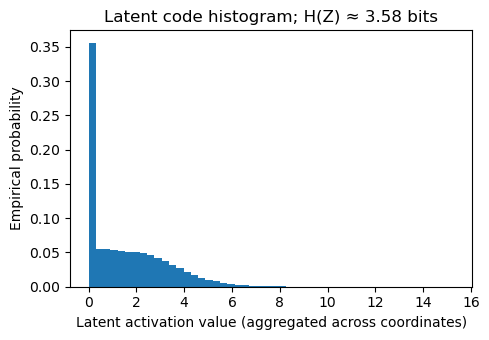

In [10]:

# Flatten all latent coordinates across the test set
z_flat = Z_test.reshape(-1)

# Build a histogram over a fixed range of latent values
num_bins = 50
counts_z, bin_edges = np.histogram(z_flat, bins=num_bins)
H_z_bits = discrete_entropy_from_hist(counts_z, base=2)
print(f"Estimated entropy of latent code H(Z): {H_z_bits:.3f} bits (via binning)")

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(5, 3.5))
plt.bar(bin_centers, counts_z / counts_z.sum(), width=(bin_edges[1]-bin_edges[0]))
plt.xlabel("Latent activation value (aggregated across coordinates)")
plt.ylabel("Empirical probability")
plt.title(f"Latent code histogram; H(Z) ≈ {H_z_bits:.2f} bits")
plt.tight_layout()
plt.savefig("figs/nn_entropy_hist_z.png", dpi=150)
plt.show()



## 8. Layerwise Entropy Comparison

Finally, we compare several entropy-type quantities:

- $H(Y)$: entropy of the **true label** distribution;
- $H_{\text{input}}$: entropy of input pixel intensities (via binning);
- $H(Z)$: entropy of the latent representation (via binning, as above);
- $H_{\text{pred}}$: **average predictive entropy** of the classifier.

This gives a rough picture of how information is processed and compressed
from inputs to outputs.


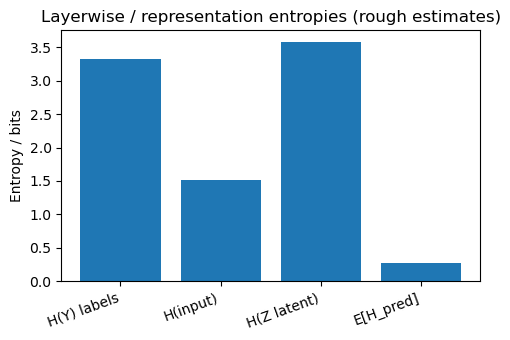

Entropy estimates (bits):
  H(Y) labels : 3.319
  H(input)    : 1.511
  H(Z latent) : 3.577
  E[H_pred]   : 0.270


In [11]:

# Entropy of input pixel intensities via binning
x_flat = X_test.reshape(-1)
num_bins_input = 50
counts_x, edges_x = np.histogram(x_flat, bins=num_bins_input)
H_input_bits = discrete_entropy_from_hist(counts_x, base=2)

# Average predictive entropy (already in H_pred_bits)
H_pred_mean_bits = float(H_pred_bits.mean())

# Prepare bar plot
labels_bar = ["H(Y) labels", "H(input)", "H(Z latent)", "E[H_pred]"]
values_bar = [H_labels_bits, H_input_bits, H_z_bits, H_pred_mean_bits]

plt.figure(figsize=(5, 3.5))
plt.bar(labels_bar, values_bar)
plt.ylabel("Entropy / bits")
plt.title("Layerwise / representation entropies (rough estimates)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("figs/nn_entropy_layerwise.png", dpi=150)
plt.show()

print("Entropy estimates (bits):")
for name, val in zip(labels_bar, values_bar):
    print(f"  {name:12s}: {val:.3f}")
